# Import Dependencies

In [ ]:
import os
import json
import random
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from scipy.stats import spearmanr
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')



In [2]:
# Setup directories
os.makedirs("results", exist_ok=True)
os.makedirs("plots", exist_ok=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 15.8 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: areebamunir (areebamunir-nust) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# Load Data

In [3]:
with open("train.json", "r") as f:
    train_data = json.load(f)

with open("dev.json", "r") as f:
    dev_data = json.load(f)

#Load Model

In [4]:
MODEL_NAME = "Qwen/Qwen2.5-1.5B-Instruct"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Load model in 4-bit
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,

    device_map="auto",
    load_in_4bit=True,
    torch_dtype=torch.float16
)

print("Model loaded in 4-bit successfully!")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Model loaded in 4-bit successfully!


# Prompt Template creation

In [5]:
def build_zero_shot_prompt(sample):
    return f"""
{sample['precontext']} **{sample['sentence']}** {sample.get('ending','')}
In this context, how plausible is it that the meaning of the word "{sample['homonym']}" is "{sample['judged_meaning']}"?
Return only the numbered score (1,2,3,4,5)
"""

def build_few_shot_prompt(sample, few_examples):
    """
    sample: dict with keys 'precontext', 'sentence', 'ending', 'homonym', 'judged_meaning'
    few_examples: list of dicts with same keys + 'average'
    Returns a string formatted for few-shot LLM prediction.
    """
    prompt = """
You will see a short text in which one sentence is marked with "**". That sentence contains a word
that can take multiple meanings, depending on the context. One of those meanings is given to you.

**Your task is simple:** Annotate how plausible a meaning of a word is in the context of the short text
using one of five scores:

* 1: The displayed meaning is not plausible at all given the context
* 2: The displayed meaning is theoretically conceivable, but less plausible than other meanings
* 3: The displayed meaning represents one of multiple, similarly plausible interpretations
* 4: The displayed meaning represents the most plausible interpretation; other meanings may still be conceivable
* 5: The displayed meaning is the only plausible meaning given the context

Always look at all of the sentences and carefully think about how plausible each meaning would be.

Take a look at the following examples:
"""

    # Add few-shot examples
    for ex in few_examples:
        prompt += f"\n{ex['precontext']} **{ex['sentence']}** {ex.get('ending','')}\n"
        prompt += f"In this context, how plausible is it that the meaning of the word \"{ex['homonym']}\" is \"{ex['judged_meaning']}\"?\n"
        prompt += f"Correct answer: {round(ex['average'])}\n---"

    # Add target sample
    prompt += f"\n\n{sample['precontext']} **{sample['sentence']}** {sample.get('ending','')}\n"
    prompt += f"In this context, how plausible is it that the meaning of the word \"{sample['homonym']}\" is \"{sample['judged_meaning']}\"?\n"
    prompt += "Return only the numbered score (1, 2, 3, 4, or 5)."

    return prompt


# Model Prediction and potting


In [6]:
train_values = list(train_data.values())
labels = np.array([int(round(v['average'])) for v in train_values])

few_examples = []

# Pick one example per score (1 to 5)
for score in range(1, 6):
    candidates = [v for v, lbl in zip(train_values, labels) if lbl == score]
    if candidates:
        few_examples.append(random.choice(candidates))

# Ensure we always have exactly 3 examples
while len(few_examples) < 3:
    few_examples.append(random.choice(train_values))


In [7]:
def get_model_prediction(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=10)
    decoded = tokenizer.decode(output[0], skip_special_tokens=True)

    # Extract first integer 1-5 from model output
    for token in decoded.split():
        if token.isdigit() and 1 <= int(token) <= 5:
            return int(token)

    # fallback
    return 3

In [ ]:
def get_average(l):
    return sum(l)/len(l)

def get_standard_deviation(l):
    return statistics.stdev(l)

def is_within_standard_deviation(pred, labels):
    avg = get_average(labels)
    stdev = get_standard_deviation(labels)
    if (avg - stdev) <= pred <= (avg + stdev):
        return True
    if abs(avg - pred) < 1:
        return True
    return False

def evaluate(predictions, gold_data):
    gold_list, pred_list = [], []
    correct, total = 0, 0
    errors = []

    for id_str, pred in predictions.items():
        labels = gold_data[id_str]['choices']
        avg = get_average(labels)
        gold_list.append(avg)
        pred_list.append(pred)

        if is_within_standard_deviation(pred, labels):
            correct += 1
        else:
            errors.append((id_str, pred, avg))
        total += 1

    # Spearman correlation
    corr, p_val = spearmanr(pred_list, gold_list)
    accuracy = correct / total

    # MAE and MSE
    mae = mean_absolute_error(gold_list, pred_list)
    mse = mean_squared_error(gold_list, pred_list)

    print(f"Spearman correlation: {corr:.4f} (p={p_val:.4f})")
    print(f"Accuracy within SD: {accuracy:.4f} ({correct}/{total})")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")

    return {
        'spearman': corr,
        'accuracy_within_std': accuracy,
        'mae': mae,
        'mse': mse,
        'errors': errors
    }



In [8]:
def plot_corrections(errors, save_path=None, metrics=None):
    """
    Plots predicted vs gold averages for errors only.

    errors: list of tuples (id_str, pred, gold_avg)
    save_path: optional path to save the figure
    metrics: optional dict with spearman, accuracy, mae, mse to show in summary
    """
    if not errors:
        print("No errors to plot!")
        return

    preds = [e[1] for e in errors]
    golds = [e[2] for e in errors]

    fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

    # 1. Predictions vs Gold (errors only)
    scatter = axes[0].scatter(golds, preds, alpha=0.7, edgecolors='black', s=50)
    axes[0].plot([min(golds), max(golds)], [min(golds), max(golds)], 'r--', label='Perfect')
    axes[0].set_xlabel("Gold Average")
    axes[0].set_ylabel("Predicted")
    axes[0].set_title("Prediction vs Gold (Errors Only)")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # 2. Absolute Error Distribution
    abs_errors = [abs(p - g) for p, g in zip(preds, golds)]
    axes[1].hist(abs_errors, bins=20, color='#4C72B0', edgecolor='black', alpha=0.7)
    axes[1].axvline(np.mean(abs_errors), color='red', linestyle='--', linewidth=2,
                    label=f'Mean: {np.mean(abs_errors):.3f}')
    axes[1].set_xlabel("Absolute Error")
    axes[1].set_ylabel("Frequency")
    axes[1].set_title("Error Distribution")
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)

    # Optional metrics display
    if metrics:
        metric_text = f"""
        Spearman: {metrics.get('spearman', 0):.4f}
        Accuracy (within SD): {metrics.get('accuracy_within_std', 0):.4f}
        MAE: {metrics.get('mae', 0):.4f}
        MSE: {metrics.get('mse', 0):.4f}
        """
        plt.figtext(0.5, -0.05, metric_text, ha='center', fontsize=11, family='monospace')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"Plot saved to {save_path}")
    plt.show()


In [9]:
zero_shot_predictions = {}

for i, (id_str, sample) in enumerate(dev_data.items(), 1):
    prompt = build_zero_shot_prompt(sample)
    pred = get_model_prediction(prompt)
    zero_shot_predictions[id_str] = pred

    print(f"[{i}/{len(dev_data)}] Sample {id_str} done, prediction: {pred} at {datetime.now().strftime('%H:%M:%S')}")

# Use the updated evaluate function
results = evaluate(zero_shot_predictions, dev_data)


[1/588] Sample 0 done, prediction: 3 at 13:16:42
[2/588] Sample 1 done, prediction: 3 at 13:16:44
[3/588] Sample 2 done, prediction: 1 at 13:16:45
[4/588] Sample 3 done, prediction: 4 at 13:16:46
[5/588] Sample 4 done, prediction: 3 at 13:16:47
[6/588] Sample 5 done, prediction: 4 at 13:16:49
[7/588] Sample 6 done, prediction: 5 at 13:16:50
[8/588] Sample 7 done, prediction: 4 at 13:16:51
[9/588] Sample 8 done, prediction: 3 at 13:16:52
[10/588] Sample 9 done, prediction: 3 at 13:16:54
[11/588] Sample 10 done, prediction: 2 at 13:16:56
[12/588] Sample 11 done, prediction: 3 at 13:16:58
[13/588] Sample 12 done, prediction: 2 at 13:16:59
[14/588] Sample 13 done, prediction: 3 at 13:17:00
[15/588] Sample 14 done, prediction: 3 at 13:17:01
[16/588] Sample 15 done, prediction: 3 at 13:17:02
[17/588] Sample 16 done, prediction: 4 at 13:17:03
[18/588] Sample 17 done, prediction: 3 at 13:17:05
[19/588] Sample 18 done, prediction: 4 at 13:17:06
[20/588] Sample 19 done, prediction: 4 at 13:17:08

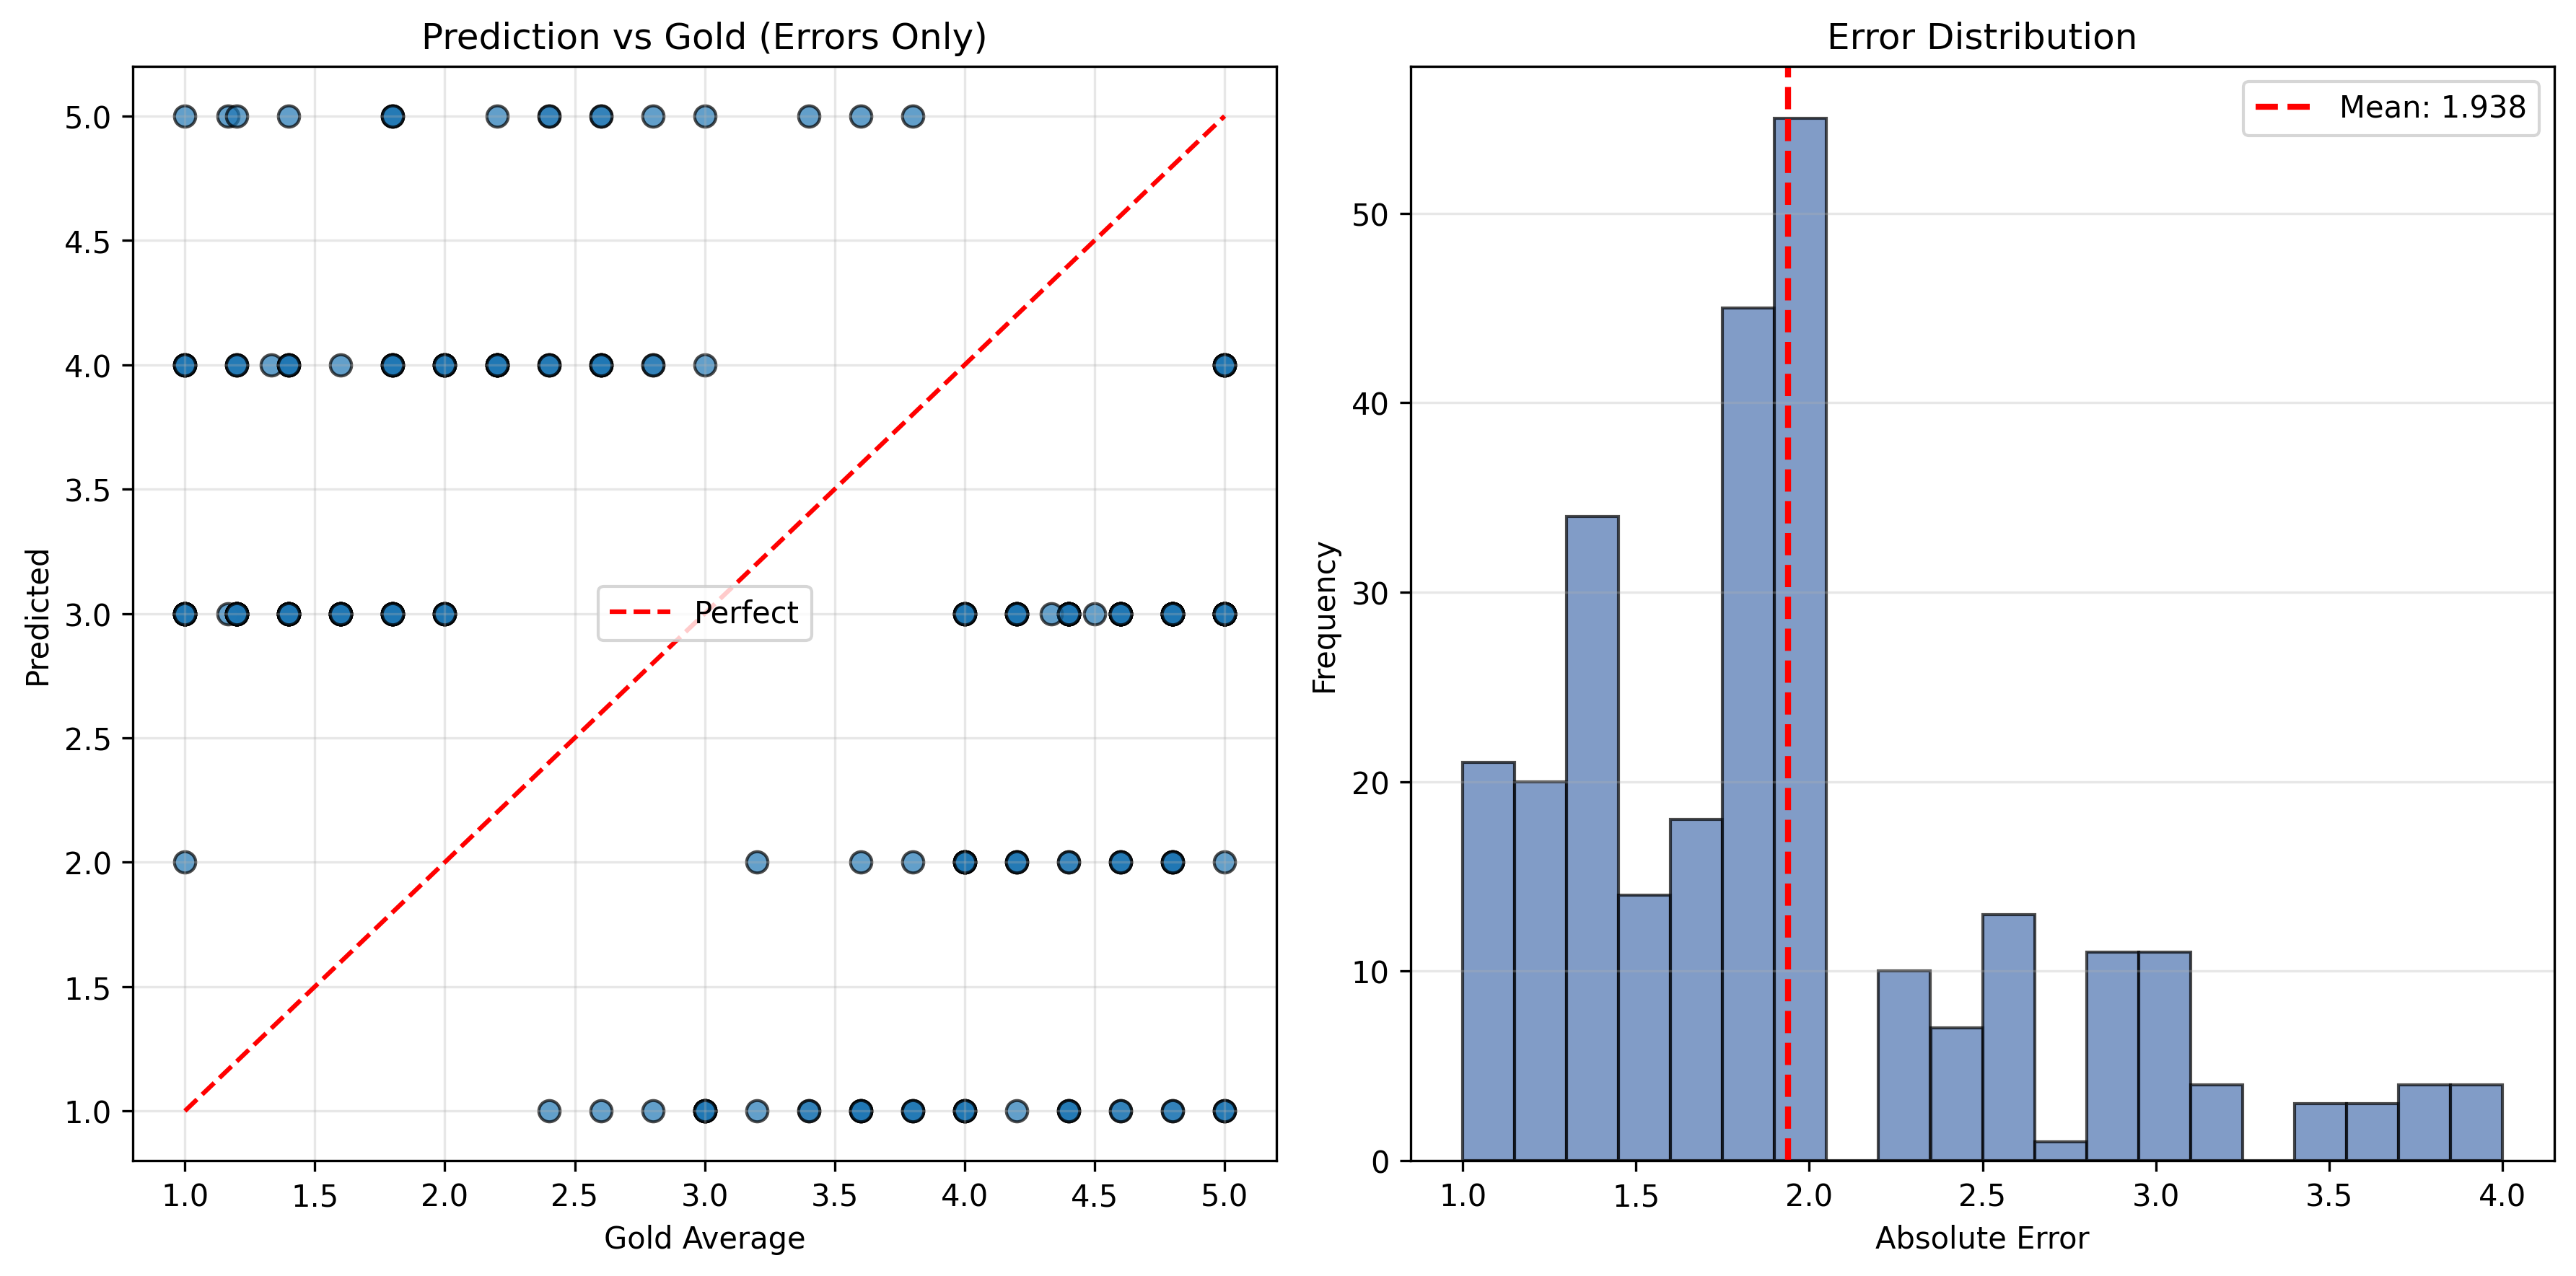

Zero-shot predictions complete! Results saved to results/zero_shot_results.json
Spearman: 0.0086, Accuracy: 0.5272, MAE: 1.2392, MSE: 2.2688


In [10]:

# Plot errors/corrections
plot_corrections(results['errors'])

# Save predictions
with open("results/zero_shot_results.json", "w") as f:
    json.dump(zero_shot_predictions, f)

print("Zero-shot predictions complete! Results saved to results/zero_shot_results.json")
print(f"Spearman: {results['spearman']:.4f}, Accuracy: {results['accuracy_within_std']:.4f}, MAE: {results['mae']:.4f}, MSE: {results['mse']:.4f}")
